# General

In this Jupyter notebook, I will replicate the paper **"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al.** with Pytorch. The paper proposes a new approach to image recognition using transformers, a type of neural network commonly used in natural language processing.

**ViT** - Stands for Vision Transformer. Short hand for the original machine learning research paper that introduced the ViT architecture, [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), anytime ViT paper is mentioned, you can be assured it is referencing this paper.

## What's ViT made of?

1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

### Exploring Figure 1

1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.
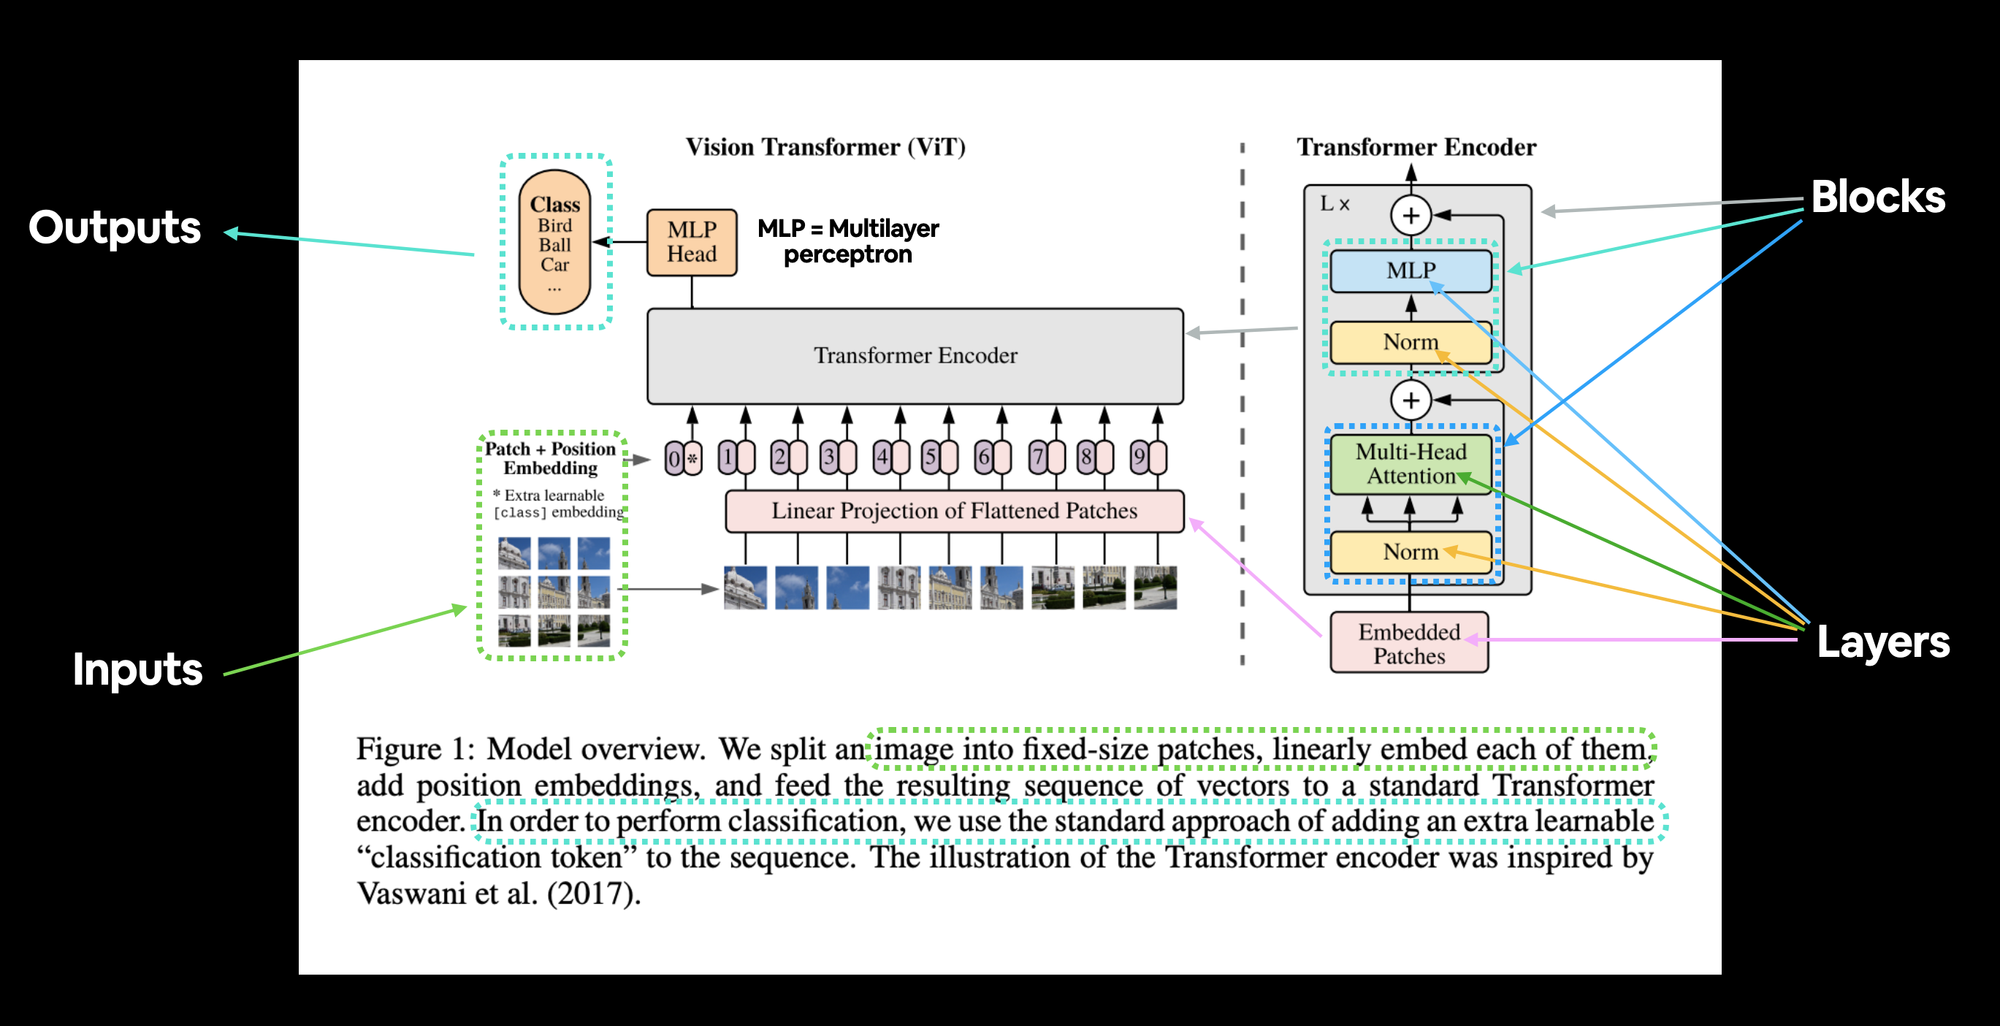

**The ViT architecture is comprised of several stages:**

- **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
- **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
- **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [torch.nn.LayerNorm()](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
- **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [torch.nn.MultiheadAttention()](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
- **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [torch.nn.GELU()](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [torch.nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
- **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

### Exploring the Four Equations
**Equtions:**
$$\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}  \qquad \space \space (1) \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \qquad \qquad \qquad \qquad \qquad \space (2) \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\mathrm{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \qquad \qquad \qquad \qquad \qquad \space (3) \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) \quad (4) & &
\end{aligned}$$

**Pseudocode:**
1) ```x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]```
2) ```x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input```
3) ```x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block```
4) ```y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

| Equation number | Description from ViT paper section 3.1 |
| --- | --- |
| 1 | The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings. | 
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches (z0 = xclass), whose state at the output of the Transformer encoder z0L serves as the image representation y (Eq. 4). |

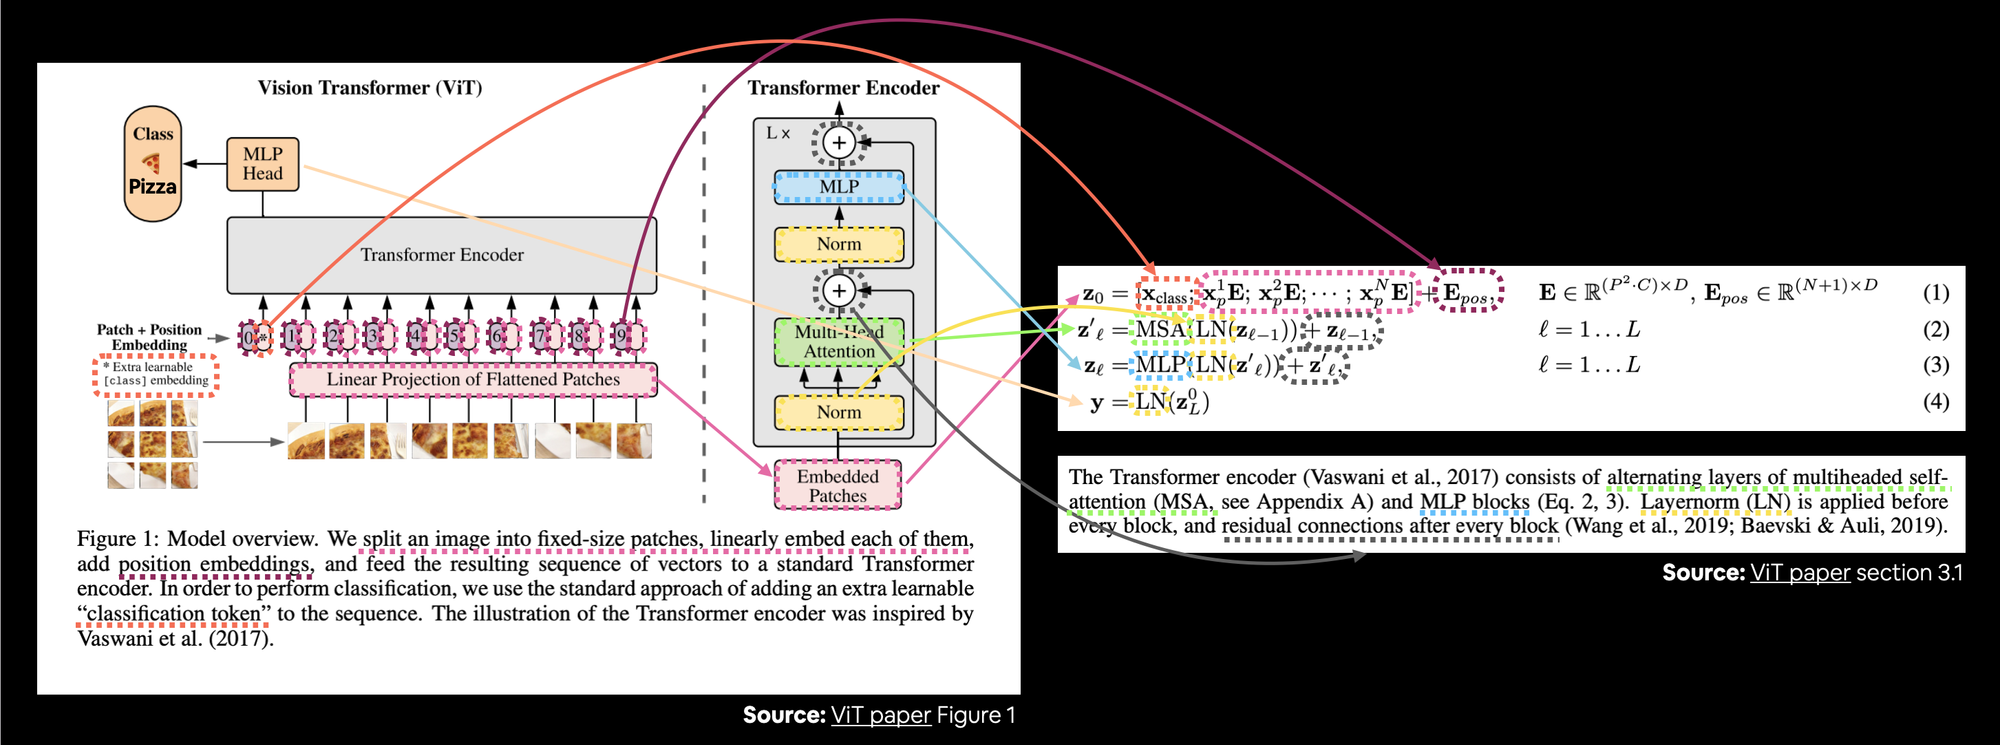

To handle $2 \mathrm{D}$  images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches , where $(H, W)$ is the **resolution** of the original image, $C$ is the **number of channels**,   $(P, P)$ is the **resolution** of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. 

The Transformer uses **constant latent vector** size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Position embeddings** are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$  position embeddings, since we have not observed significant performance
gains from using more advanced $2 \mathrm{D}$-aware position embeddings. The resulting sequence of embedding vectors serves as **input** to the encoder.

### Exploring Table 1 (various hyperparameters of each of the ViT architectures)

| Model | Layers | Hidden size D | MLP size | Heads | Params |
| --- | --- | --- | --- | --- | --- |
ViT-Base|12|768|3072|12|86M
ViT-Large|24|1024|4096|16|307M
ViT-Huge|32|1280|5120|16|632M

**Breaking the hyperparameters down:**
- **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
- **Hidden size D** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
- **MLP size** - What are the number of hidden units in the MLP layers?
- **Heads** - How many heads are there in the Multi-Head Attention layers?
- **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

# Preparation

This chapter will contain code for creating modular Python files for next tasks:
- **Data downloading** - ```data_downloader.py```
- **Helper functions** for training, visualizations etc. - ```utils.py```

## Script for data downloading
For this task i decided to use open dataset from Kaggle called [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10?resource=download), contains images with ten different animals.

In [9]:
%%writefile data_download.py

import os
import pathlib
import zipfile
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

from tqdm import tqdm

def data_downloader(dataset_key='alessiocorrado99/animals10',
                    kaggle_username='seblful',
                    kaggle_api='6757c11d0dc1367e16a1a6b9fab157d1'):
    '''
    Downloads data from Kaggle, creates new directories,
    and deletes old files
    '''
    data_path = pathlib.Path('data')
    
    # Check if directory 'data' in repository
    if data_path.is_dir() == False: # change to false
        os.mkdir('data')
        print("There are no have directory 'data', creating new one")
        
        # Setting Kaggle environment
        os.environ['KAGGLE_USERNAME'] = kaggle_username
        os.environ['KAGGLE_KEY'] = kaggle_api

        api = KaggleApi()
        api.authenticate()
        
        with tqdm(total=100) as t:
            # Download data from Kaggle 
            print('Downloading data...')
            api.dataset_download_files(dataset_key, path=data_path)
            print('Data has downloaded')
        
        with tqdm(total=100) as t:
            # Getting name of archive
            zip_path = list(data_path.glob('*.zip'))[0]
            # Extracting files from archive
            print('Extracting files from archive...')
            with zipfile.ZipFile(zip_path, 'r') as zip_file:
                zip_file.extractall(data_path)
            print('Files has extracted')

            # Deleting zipfile
            try:
                os.remove(zip_path)
            except PermissionError as ex:
                print(f"Couldn't delete zip file for {ex}")

        # Check if data_path doesn't contain additional directories inside and deleting if does
        list_of_dirs_in_data = [file for file in data_path.iterdir() if file.is_dir()]
        print(list_of_dirs_in_data)
        if len(list_of_dirs_in_data) == 1:
            added_dir_path = list_of_dirs_in_data[0]
            
            list_of_dirs_in_added_dir = os.listdir(added_dir_path)
            
            # Looping through each folder in added dir and moving to data_path
            for image_class in list_of_dirs_in_added_dir:
                original_path = added_dir_path / image_class
                print('Orig', original_path)
                
                new_path = data_path / image_class
                print('new_path', new_path)
                # Moving files
                shutil.move(original_path, new_path)
            print('Folders has removed')
            
            # Deleting emptyExceptionded folder
            try:
                os.remove(added_dir_path)
            except PermissionError as ex:
                print(f"Couldn't delete added dir path for {ex}")
        
        # Checking presence of translate file to rename folders and renaming them
        translate_file_path = data_path / 'translate.py'
        if translate_file_path.is_file():
            # Importing dict with translation
            from data.translate import translate
            # Adding missing key
            translate['ragno'] = 'spider'
            translate['raw-img'] = 'raw-img'
            translate['__pycache__'] = '__pycache__'
            
            # Creating list with folders
            list_of_dirs_in_data = [file for file in data_path.iterdir() if file.is_dir()]
            # Looping through folders in data_path and rename folders
            for folder in list_of_dirs_in_data:
                folder.rename(data_path / translate[folder.name])
                print('Name of folders has renamed')
                
            try:
                os.remove(data_path/'translate.py')
            except PermissionError as ex:
                print(f"Couldn't delete translate.py for {ex}")

    else:
        print("The repository has directory 'data'")

data_downloader()

Overwriting data_download.py


## Utils script

This script contains several functions for creating dataloaders, training, visualisations

In [95]:
%%writefile utils.py

import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

def make_dataloaders(data_path, 
                     train_size=0.85,
                     test_size=0.15,
                     batch_size=32):
    '''
    Creates train and test dataloaders
    '''
    # Defining num workers
    num_workers = os.cpu_count()
    
    # Creating transformer to transform data
    transformer = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
        ])
    
    # Creating train and test dataset
    full_dataset = datasets.ImageFolder(root=data_path,
                                        transform=transformer)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    

    # Creating train and test dataloader
    train_dataloader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers,
                                 pin_memory=True)
    
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=True)
    
    return train_dataloader, test_dataloader, full_dataset.classes, full_dataset.class_to_idx

Overwriting utils.py
